# PatchCore Example

#### Import dependencies

In [2]:
import os
import anodet
import numpy as np
import torch
import cv2
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 

## Training

In this notebook the MVTec dataset will be used. It can be downloaded from: https://www.mvtec.com/company/research/datasets/mvtec-ad.

Change `DATASET_PATH` to the path where you save the dataset.

Also, if you want to save and load the model. Add a folder where to save them and change the path of `MODEL_DATA_PATH` to that folder.

In [3]:
DATASET_PATH = os.path.realpath("../../data/mvtec_dataset/")
MODEL_DATA_PATH = os.path.realpath("./distributions/")

#### Load dataset

In [4]:
dataset = anodet.AnodetDataset(os.path.join(DATASET_PATH, "bottle/train/good"))
dataloader = DataLoader(dataset, batch_size=32)
print("Number of images in dataset:", len(dataloader.dataset))

Number of images in dataset: 209


#### Init the model

In [5]:
patch_core = anodet.PatchCore()

#### Fit the model to the dataset

In [6]:
patch_core.fit(dataloader)

Feature extraction:   0%|          | 0/7 [00:00<?, ?it/s]

Feature extraction: 100%|██████████| 7/7 [00:19<00:00,  2.76s/it]


Getting transformed features...
Calculating distances...
Maximum distance from cluster centers is 2.05


#### Save the necessary parameters

In [7]:
torch.save(patch_core.embedding_coreset, os.path.join(MODEL_DATA_PATH, "bottle_embedding_coreset.pt"))

# 

## Inference
#### Load test images

In [8]:
paths = [
    os.path.join(DATASET_PATH, "bottle/test/broken_large/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/broken_small/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/contamination/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/good/000.png"),
    os.path.join(DATASET_PATH, "bottle/test/good/001.png"),
]

images = []
for path in paths:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    
batch = anodet.to_batch(images, anodet.standard_image_transform, torch.device('cpu'))

#### Load the model data

In [9]:
embedding_coreset = torch.load(os.path.join(MODEL_DATA_PATH, 'bottle_embedding_coreset.pt'))

#### init the model

In [10]:
patch_core = anodet.PatchCore('resnet18', embedding_coreset=embedding_coreset)

#### Make prediction

In [11]:
image_scores, score_maps = patch_core.predict(batch)

#### Interpret the prediction

In [12]:
THRESH = 2.4
score_map_classifications = anodet.classification(score_maps, THRESH)
image_classifications = anodet.classification(image_scores, THRESH)
print("Image scores:", image_scores)
print("Image classifications:", image_classifications)

Image scores: tensor([3.0991, 2.1903, 2.7485, 1.7736, 1.6348])
Image classifications: tensor([0., 1., 0., 1., 1.])


#### Visualization

In [13]:
test_images = np.array(images).copy()

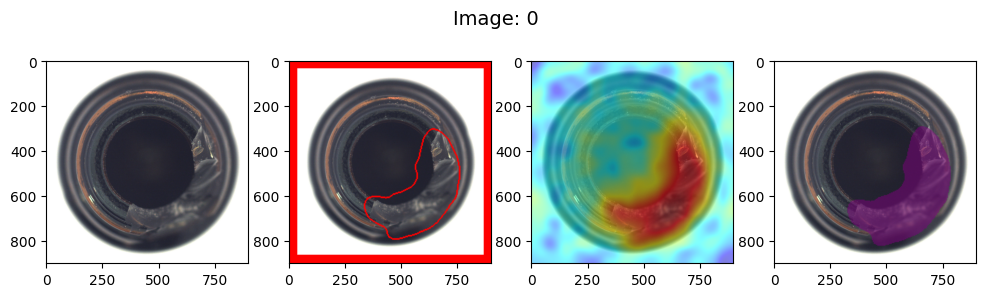

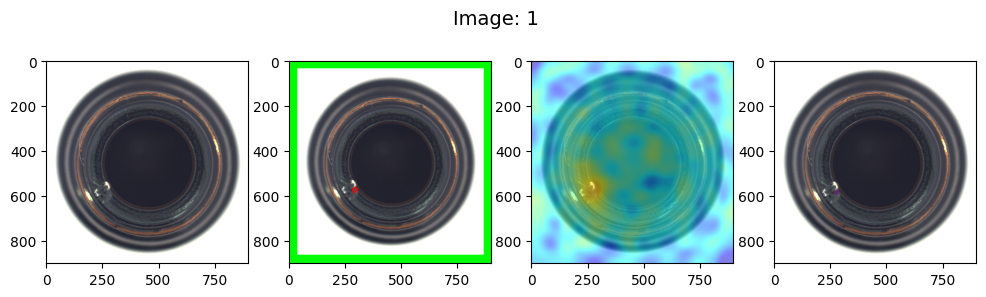

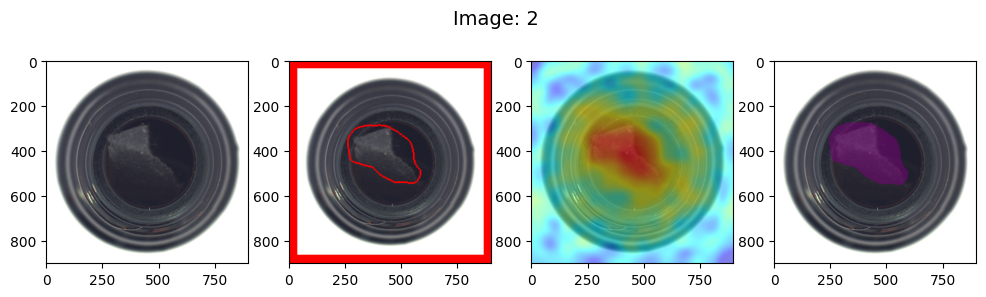

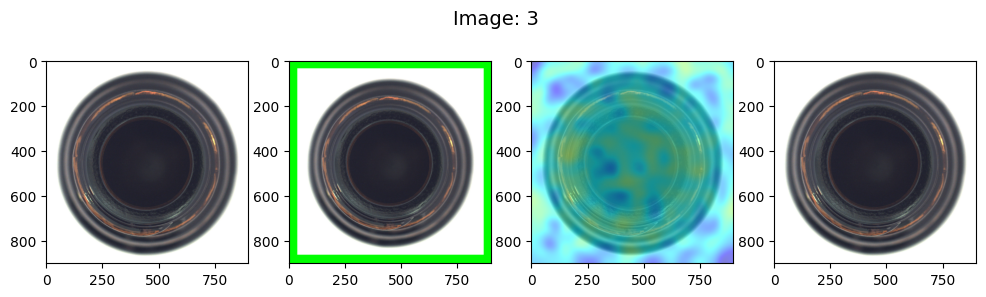

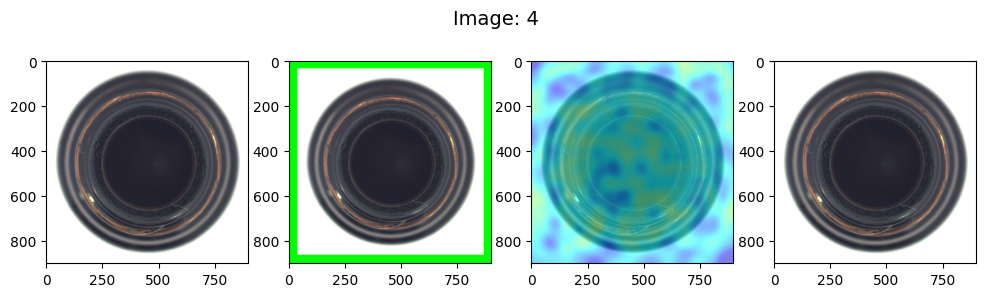

In [14]:
boundary_images = anodet.visualization.framed_boundary_images(test_images, score_map_classifications, image_classifications, padding=40)
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
highlighted_images = anodet.visualization.highlighted_images(images, score_map_classifications, color=(128, 0, 128))

for idx in range(len(images)):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    fig.suptitle('Image: ' + str(idx), y=0.75, fontsize=14)
    axs[0].imshow(images[idx])
    axs[1].imshow(boundary_images[idx])
    axs[2].imshow(heatmap_images[idx])
    axs[3].imshow(highlighted_images[idx])
    plt.show()

#### For one merged image

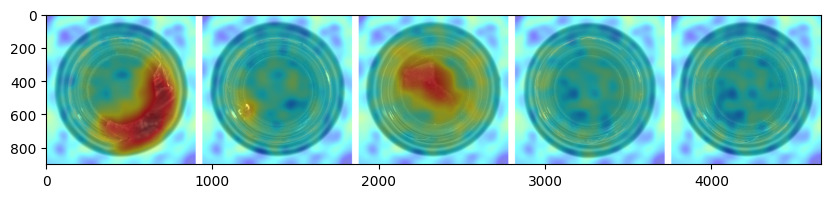

In [15]:
heatmap_images = anodet.visualization.heatmap_images(test_images, score_maps, alpha=0.5)
tot_img = anodet.visualization.merge_images(heatmap_images, margin=40)
fig, axs = plt.subplots(1, 1, figsize=(10, 6))
plt.imshow(tot_img)
plt.show()

## Evaluation

In [16]:
class_name = 'bottle'
test_dataset = anodet.MVTecDataset(DATASET_PATH, class_name, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=32)

In [18]:
res = patch_core.evaluate(test_dataloader)
images, image_classifications_target, masks_target, image_scores, score_maps = res

Inference: 100%|██████████| 3/3 [00:12<00:00,  4.27s/it]


Image level
ROC-AUC score: 1.0

Optimal thresh: 2.0333505
Recall: 1.0
Precision: 1.0


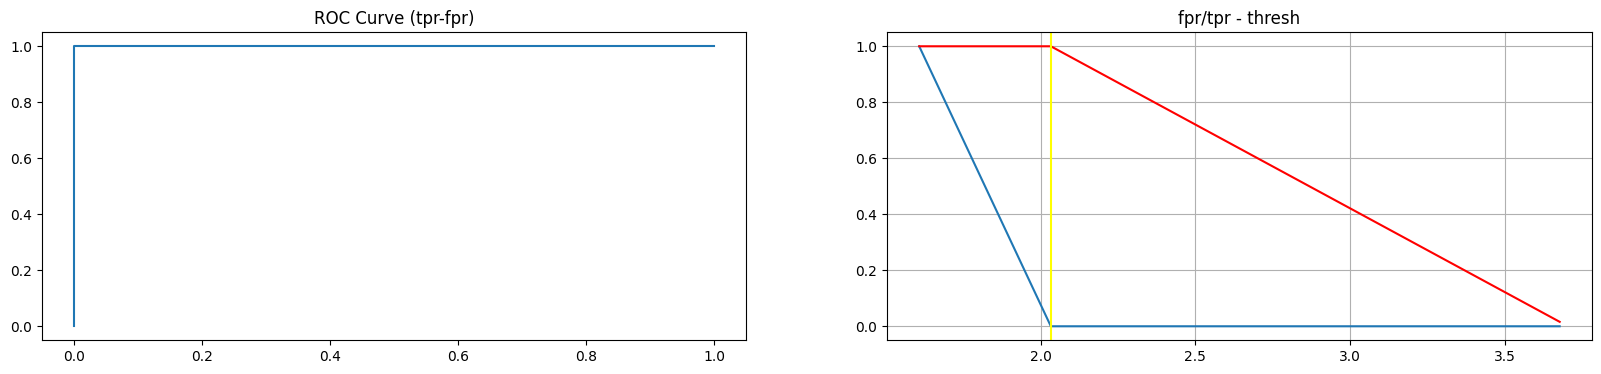

Pixel level
ROC-AUC score: 0.9769803143386254

Optimal thresh: 2.27213
Recall: 0.789408215237225
Precision: 0.5663163155042558


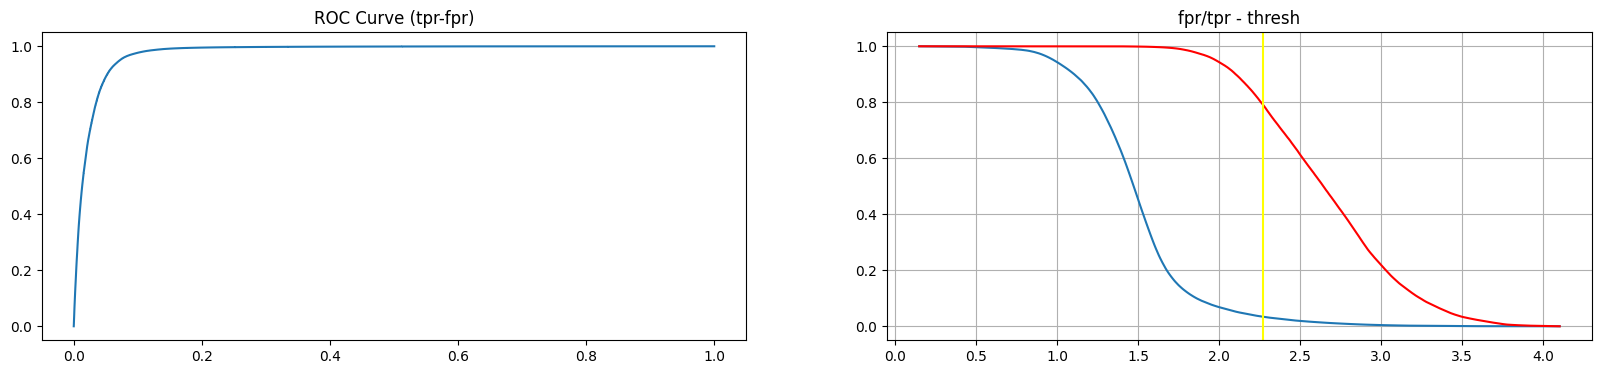

In [19]:
anodet.visualize_eval_data(image_classifications_target, masks_target, image_scores, score_maps)